In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from utils.misc import *
from utils.misc import Predicate, count_neg, get_first_neg_index
from utils.misc import count_
from utils.operators import negation
from utils.operators import weak_conjunction, strong_conjunction
from utils.operators import weak_disjunction, strong_disjunction
from utils.operators import implication

%matplotlib inline

# Goal
- winston benchmark を解く

## 一時目標 
- toy problem を手動の導出なしで解く
- 


### TO DO
- 演算の定義
- 記号と処理の対応付け
- 演算の順番の実装
- predicate に対しても p_j を割り当て （ex. mammal(x) =: p_2(x）)
- 上から読み込んでいったとしたら 初めてでてきた predicate を認識して


### Notes

- 解釈の順番 否定を先
- 論理式（KB）の書き方を少し制限する
-
- とりあえず，分配法則を使用した書き方を禁止する
- 2重否定もとりあえず許さない
-
- p(x) ○ q(x) 以上の formula を解析しようとするともう少し抽象度をあげなければいけない
- 受け取った formula を空白で区切って要素ごとに分解しリストを作成
- 演算子を認識して前から順に演算
- 演算を終えるごとに，リストを更新し，リストの要素数が 1 かつ，それが演算子でなくなるまで演算を繰り返す
- 
- 
- 与えられた formula の構文チェッカーを作成しても良いかもしれない
- 
- [p_1(x_test), '→', '¬', p_2(x_test), '→', '¬', p_3(x_test)] のような str と cp.Variable が混ざったリストに対して .count や .index ができない
- ループなどを使ってカウントするしか無い
- 
- p を cvxpy で書いたら affine ではなくなった
- おそらく 含意 がわるい
- min, max を取る操作を含むと affine ではなくなる
- min(x, y) >= val  <=>  x >= val と y >= val
- max(x, y) <= val  <=>  x >= val と y <= val
- 
- どこまで式変形すれば affine のまま不等式が定義できるか
- 結果として制約の数が増えても良い
- min(x, y) >= val  <=>  x >= val と y >= val を使って min を消す
- ~~max(x, y) <= val  <=>  x <= val と y <= val を使って max を消す~~
- logical <= ξ なので，1 - min(・, ・) として，不等式を並べる方向式変形する
- x '∨' y <= ξ が出てきたらどうするか（Example 3 がその例）
- 
- 矛盾する制約（ξ <= -1 and ξ <= 1）のようながある時どうなるのか
- とりあえず上は考えない （convex (concave) fragments の中で閉じてるはずなので）
- 
- 
- 制約が affine でなくなるのを防止するために不等式を分割すると上手く計算できることが確認できた
- あとは formula の変換プログラムを完成させるだけ
- 
- 排他的論理和 ⊕ の分配法則を勘違いしていた 
- x ⊕ (y ∧ z) = (x ⊕ y) ∧ (x ⊕ z)
- 
- 分配法則を処理できるようにしないといけないかもしれない 
- 
- ホーン節とか，誤植とか
- 定義をしっかり覚えておかしいところは気づかないといけない
- ホーン節チェッカーを作成しても良いかもしれない
- 
- 
- 
- 
- 
- 
- 
- 
- 



#### 目印になりそうなもの

- 半角スペース
- ()
- () の左に隣接する文字列
- 

In [2]:
# load and convert data, describe problem settings, etc
data_dir_path = './inputs/toy_data/'
path_L1 = os.path.join(data_dir_path, 'L1.csv')
path_L2 = os.path.join(data_dir_path, 'L2.csv')
path_L3 = os.path.join(data_dir_path, 'L3.csv')
path_U = os.path.join(data_dir_path, 'U.csv')

df_L1 = pd.read_csv(path_L1, index_col=0)
df_L2 = pd.read_csv(path_L2, index_col=0)
df_L3 = pd.read_csv(path_L3, index_col=0)
df_U = pd.read_csv(path_U, index_col=0)

L1 = np.array(df_L1)
L2 = np.array(df_L2)
L3 = np.array(df_L3)

L = np.stack([L1, L2, L3]) # data for pointwise constraint
U = np.array(df_U) # data for logical constriant

In [3]:
symbols_1 = ['¬', '∧', '∨', '⊗', '⊕', '→']

operations = [
    negation,
    weak_conjunction,
    weak_disjunction,
    strong_conjunction,
    strong_disjunction,
    implication
]

symbols_1_semanticized = {s: o for s, o in zip(symbols_1, operations)}

In [4]:
len_j = 3 
len_h = 2

w_j = cp.Variable(shape=(len_j, 3))

w_1 = w_j[0, :]
w_2 = w_j[1, :]
w_3 = w_j[2, :]

xi_h = cp.Variable(shape=(len_h, 1), nonneg=True)
xi_1, xi_2 = xi_h[0, :], xi_h[1, :]
xi_1, xi_2


p_1 = Predicate(w_1).func
p_2 = Predicate(w_2).func
p_3 = Predicate(w_3).func

x_test = np.random.rand(2)

In [5]:
w_4 = cp.Variable(shape=(3))
p_4 = Predicate(w_4).func

In [43]:
# f = 'darkspots(x) → ¬ blackstripes(x)'
# f_decomp = f.split()

# f_decomp = [0.5, '→', '¬', 0.3, '→', '¬', 0.3, '→', '¬', 0.3]

In [95]:
def formula_transformer(formula_decomposed):
    neg_num = count_neg(formula_decomposed)

    while neg_num > 0:
        target_index = get_first_neg_index(formula_decomposed)

        # 演算に使用する値を取得
        x = formula_decomposed[target_index + 1]

        # 演算の実行
        operation = symbols_1_semanticized['¬']
        result = operation(x)

        # 演算結果で置き換え，演算子（¬）の削除
        formula_decomposed[target_index + 1] = result
        formula_decomposed.pop(target_index)

        neg_num -= 1

    while len(formula_decomposed) > 1:
        target_index = None

        # 分割された formula （リスト）から最初の演算子のインデックスを取得
        for index, token in enumerate(formula_decomposed):
            if token in symbols_1_semanticized.keys():
                target_index = index
                break

        # 対応する演算子の関数を取得
        symbol = formula_decomposed[target_index]
        operation = symbols_1_semanticized[symbol]

        # 演算に使用する値のペアを取得
        x = formula_decomposed[target_index - 1]
        y = formula_decomposed[target_index + 1]

        # 実際に演算を行う
        result = operation(x, y)

        # 演算結果で置き換え，演算済み要素の削除

        formula_decomposed[target_index] = result
        indices_to_remove = [target_index - 1, target_index + 1]
        filtered = []

        for i, item in enumerate(formula_decomposed):
            if i not in indices_to_remove:
                filtered.append(item)

        formula_decomposed = filtered

    return formula_decomposed[0]

In [45]:
logical_constraints = []

for u in U:
    f_decomp = [p_1(u), '→', p_2(u)]
    f_trans = formula_transformer(f_decomp)
    logical_constraints += [
        1 - f_trans <= xi_1
    ]

for u in U:
    f_decomp = [p_2(u), '→', p_3(u)]
    f_trans = formula_transformer(f_decomp)
    logical_constraints += [
        1 - f_trans <= xi_2
    ]

logical_constraints

[Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ())),
 Inequality(Expression(CONVEX, UNKNOWN, ()))]

In [101]:
f_decomp = [0.5, '→', '¬', 0.3, '→', '¬', 0.3, '→', '¬', 0.3]
f_processed = formula_transformer(f_decomp)
f_processed.value

array(1.)

'¬', '∧', '∨', '⊗', '⊕', '→'

hair(x) → mammal(x)
milk(x) → mammal(x)
feather(x) → bird(x)
layeggs(x) → bird(x)
mammal(x) ⊗ meat(x) → carnivore(x)
mammal(x) ⊗ pointedteeth(x) ⊗ claws(x) ⊗ forwardeyes(x) → carnivore(x)
mammal(x) ⊗ hoofs(x) → ungulate(x)
mammal(x) ⊗ cud(x) → ungulate(x)
carnivore(x) ⊗ tawny(x) ⊗ darkspots(x) → cheetah(x)
carnivore(x) ⊗ tawny(x) ⊗ blackstripes(x) → tiger(x)
ungulate(x) ⊗ longlegs(x) ⊗ longneck(x) ⊗ tawny(x) ⊗ darkspots(x) → giraffe(x)
ungulate(x) ⊗ white(x) ⊗ blackstripes(x) → zebra(x)
bird(x) ⊗ longlegs(x) ⊗ longneck(x) ⊗ black(x) → ostrich(x)
bird(x) ⊗ swim(x) ⊗ blackwhite(x) → penguin(x)
bird(x) ⊗ goodflier(x) → albatross(x)
cheetah(x) ⊕ tiger(x) ⊕ giraffe(x) ⊕ zebra(x) ⊕ ostrich(x) ⊕ penguin(x) ⊕ albatross(x)
mammal(x) ⊕ bird(x)
hair(x) ⊕ feather(x)
darkspots(x) → ¬ blackstripes(x)
blackstripes(x) → ¬ darkspots(x)
tawny(x) → ¬ black(x) ∧¬ white(x)
black(x) → ¬ tawny(x) ∧¬ white(x)
white(x) → ¬ black(x) ∧¬ tawny(x)
black(x) → ¬ white(x)
black(x) → ¬ tawny(x)
white(x) → ¬ black(x)
white(x) → ¬ tawny(x)
tawny(x) → ¬ white(x)
tawny(x) → ¬ black(x)


In [15]:
# f = "mammal(x) ⊗ pointedteeth(x) ⊗ claws(x) ⊗ forwardeyes(x) → carnivore(x)".split()
f = [p_1(x_test), '⊗', p_2(x_test), '⊗', p_3(x_test), '→', p_4(x_test)]

In [17]:
def formula_simplifyer(formula_decomposed):
    neg_num = count_neg(formula_decomposed)

    while neg_num > 0:
        target_index = get_first_neg_index(formula_decomposed)

        # 演算に使用する値を取得
        x = formula_decomposed[target_index + 1]

        # 演算の実行
        operation = symbols_1_semanticized['¬']
        result = operation(x)

        # 演算結果で置き換え，演算子（¬）の削除
        formula_decomposed[target_index + 1] = result
        formula_decomposed.pop(target_index)

        neg_num -= 1
    
    



    return formula_decomposed

In [18]:
f_decomp = [p_1(x_test), '⊗', p_2(x_test), '⊗', p_3(x_test), '→', p_4(x_test)]
f_simp = formula_simplifyer(f_decomp)
f_simp

[Expression(AFFINE, UNKNOWN, ()),
 '⊗',
 Expression(AFFINE, UNKNOWN, ()),
 '⊗',
 Expression(AFFINE, UNKNOWN, ()),
 '→',
 Expression(AFFINE, UNKNOWN, ())]

In [ ]:
f = f_simp

iter_num = count_(f)

for i in range(iter_num):
    target_idx = None
    for i, token in enumerate(f):
        if type(token) == str:
            if token == '→':
                target_idx = i
                break

    # print(target_idx)

    x = f[:target_idx]
    y = f[target_idx + 1]

    x_new = 1
    y_new = 1 - x + y

    f[target_idx - 1] = x_new
    f[target_idx]     = '∧'
    f[target_idx + 1] = y_new



In [119]:
x = cp.Variable()
y = cp.Variable()

x, y, x + 2

(Variable(()), Variable(()), Expression(AFFINE, UNKNOWN, ()))

In [120]:
cp.minimum(x, y)

Expression(CONCAVE, UNKNOWN, ())

In [121]:
cp.minimum(cp.minimum(x, y), x)

Expression(CONCAVE, UNKNOWN, ())

In [122]:
cp.minimum(cp.maximum(x, y), x)

Expression(UNKNOWN, UNKNOWN, ())

Expression(AFFINE, UNKNOWN, ())

In [58]:
f = [p_2(x_test), '→', p_3(x_test)]
tmp = formula_transformer(f)
print(tmp)

minimum(1.0, 1.0 + -var491[1, 0:3][0] @ 0.0006011627517461537 + var491[1, 0:3][1] @ 0.43510083680227984 + var491[1, 0:3][2] + var491[2, 0:3][0] @ 0.0006011627517461537 + var491[2, 0:3][1] @ 0.43510083680227984 + var491[2, 0:3][2])


In [76]:
f = [p_2(x_test), '→', p_3(x_test)]
print(f)

target_idx = None
for i, token in enumerate(f):
    if type(token) == str:
        if token == '→':
            target_idx = i
            break

# print(target_idx)

x = f[target_idx - 1]
y = f[target_idx + 1]

x_new = 1
y_new = 1 - x + y

f[target_idx - 1] = x_new
f[target_idx]     = '∧'
f[target_idx + 1] = y_new

f

[Expression(AFFINE, UNKNOWN, ()), '→', Expression(AFFINE, UNKNOWN, ())]


[1, '∧', Expression(AFFINE, UNKNOWN, ())]

In [52]:
tmp = ['⊕', '→']
f = [p_1(x_test), '∧', p_2(x_test), '→', p_3(x_test)]
print(f)

target_idx = None
for i, token in enumerate(f):
    if type(token) == str:
        if token in tmp:
            target_idx = i
            break

# print(target_idx)

x = f[:(target_idx - 1)]
y = f[target_idx + 1]

x_new = 1
y_new = x + y

f[target_idx - 1] = x_new
f[target_idx]     = '∧'
f[target_idx + 1] = y_new

f

[Expression(AFFINE, UNKNOWN, ()), '∧', Expression(AFFINE, UNKNOWN, ()), '→', Expression(AFFINE, UNKNOWN, ())]


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

In [85]:
# load and convert data, describe problem settings, etc
data_dir_path = './inputs/toy_data/'
path_L1 = os.path.join(data_dir_path, 'L1.csv')
path_L2 = os.path.join(data_dir_path, 'L2.csv')
path_L3 = os.path.join(data_dir_path, 'L3.csv')
path_U = os.path.join(data_dir_path, 'U.csv')

df_L1 = pd.read_csv(path_L1, index_col=0)
df_L2 = pd.read_csv(path_L2, index_col=0)
df_L3 = pd.read_csv(path_L3, index_col=0)
df_U = pd.read_csv(path_U, index_col=0)

L1 = np.array(df_L1)
L2 = np.array(df_L2)
L3 = np.array(df_L3)

L = np.stack([L1, L2, L3]) # data for pointwise constraint
U = np.array(df_U) # data for logical constriant

len_j = 3 # number of tasks (p の数)
len_h = 2 # number of logical constraints considered (cardinality of KB)

len_l = 4
len_u = 6
len_s = 10

len_jl = 0 # number of pointwise constraints to be counted later


len_l_list = [] # L_j の要素数のリスト
len_s_list = [] # S_j の要素数のリスト
S = [] # data for consistency constraints 

for i in range(len_j):
    if len_h != 0:
        u = len(U)
        S_i = np.concatenate((L[i][:, :2], U), axis=0)
        S.append(S_i)
    else:
        u = 0
        S_i = L[i][:, :2]
        S.append(S_i)
    len_l_list.append(len(L[i]))
    len_jl += len(L[i])
    len_s_list.append(len(S_i))

S = np.stack(S)


c1 = 2.5 # degree of satisfaction for pointwise slacks
c2 = 2.5 # degree of satisfaction for logical slacks

c1 = 100
c2 = 100


w_j = cp.Variable(shape=(len_j, 3))
xi_j_l = cp.Variable(shape=(len_j, len_l), nonneg=True)
xi_h = cp.Variable(shape=(len_h, 1), nonneg=True)



# 目的関数
function = 0

for j in range(len_j):
    w = w_j[j]
    function += 1/2 * (cp.norm2(w) ** 2)

for j in range(len_j):
    for l in range(len_l):
        xi = xi_j_l[j, l]
        function += c1 * xi

for h in range(len_h):
    xi = xi_h[h, 0]
    function += c2 * xi

objective_function = cp.Minimize(function)



# 制約
constraints = []

class Predicate:
    def __init__(self, w):
        self.w1 = w[0]
        self.w2 = w[1]
        self.b = w[2]

    def func(self, x):
        x1, x2 = x[0], x[1]
        return self.w1 * x1 + self.w2 * x2 + self.b


# pointwise
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w).func 
    # p = predicate

    for l in range(len_l):
        x = L[j][l, :2]
        y = L[j][l, 2]

        xi = xi_j_l[j, l]

        constraints += [
            y * (2 * p(x) - 1) >= 1 - 2 * xi
            # y * (2 * p(x, w) - 1) >= 1 - 2 * xi
        ]



# logical
for h in range(len_h):
    w_1 = w_j[h]
    w_2 = w_j[h + 1]

    p_j = Predicate(w_1).func
    p_k = Predicate(w_2).func

    xi = xi_h[h, 0]

    for u in range(len_u):
        x = U[u]

        f1 = 1
        f2 = negation(p_j(x)) + p_k(x)

        constraints += [
            1 - f1 <= xi,
            1 - f2 <= xi
        ]


# logical
for h in range(len_h):
    w_1 = w_j[h]
    w_2 = w_j[h + 1]

    p_j = Predicate(w_1).func
    p_k = Predicate(w_2).func
    # p = predicate

    xi = xi_h[h, 0]

    for u in range(len_u):
        x = U[u]

        constraints += [
            p_j(x) - p_k(x) <= xi,
            # p(x, w_1) - p(x, w_2) <= xi,
        ]


# consistency
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w).func
    # p = predicate

    for s in range(len_s):
        x = S[j][s]

        constraints += [
            p(x) >= 0,
            p(x) <= 1,
            # p(x, w) >= 0,
            # p(x, w) <= 1,
        ]


problem = cp.Problem(objective_function, constraints)
result = problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 07 02:37:56 PM: Your problem has 23 variables, 108 constraints, and 0 parameters.
(CVXPY) Oct 07 02:37:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 07 02:37:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 07 02:37:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 07 02:37:56 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 07 02:37:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

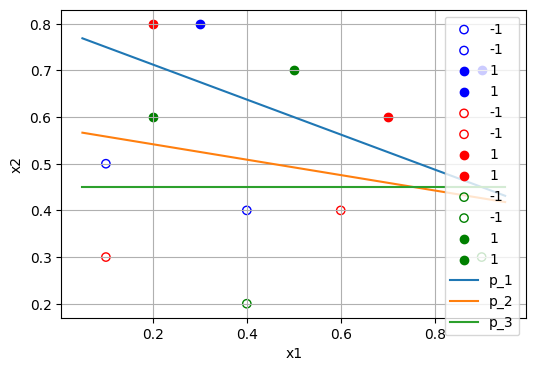

In [86]:
coeff_0 = w_j.value[0]
coeff_1 = w_j.value[1]
coeff_2 = w_j.value[2]
coeffs = [coeff_0, coeff_1, coeff_2]


def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)



plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(len_j):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# load and convert data, describe problem settings, etc
data_dir_path = './inputs/toy_data/'
path_L1 = os.path.join(data_dir_path, 'L1.csv')
path_L2 = os.path.join(data_dir_path, 'L2.csv')
path_L3 = os.path.join(data_dir_path, 'L3.csv')
path_U = os.path.join(data_dir_path, 'U.csv')

df_L1 = pd.read_csv(path_L1, index_col=0)
df_L2 = pd.read_csv(path_L2, index_col=0)
df_L3 = pd.read_csv(path_L3, index_col=0)
df_U = pd.read_csv(path_U, index_col=0)

L1 = np.array(df_L1)
L2 = np.array(df_L2)
L3 = np.array(df_L3)

L = np.stack([L1, L2, L3]) # data for pointwise constraint
U = np.array(df_U) # data for logical constriant

len_j = 3 # number of tasks (p の数)
len_h = 2 # number of logical constraints considered (cardinality of KB)

len_l = 4
len_u = 6
len_s = 10

len_jl = 0 # number of pointwise constraints to be counted later


len_l_list = [] # L_j の要素数のリスト
len_s_list = [] # S_j の要素数のリスト
S = [] # data for consistency constraints 

for i in range(len_j):
    if len_h != 0:
        u = len(U)
        S_i = np.concatenate((L[i][:, :2], U), axis=0)
        S.append(S_i)
    else:
        u = 0
        S_i = L[i][:, :2]
        S.append(S_i)
    len_l_list.append(len(L[i]))
    len_jl += len(L[i])
    len_s_list.append(len(S_i))

S = np.stack(S)


c1 = 2.5 # degree of satisfaction for pointwise slacks
c2 = 2.5 # degree of satisfaction for logical slacks

c1 = 100
c2 = 100


w_j = cp.Variable(shape=(len_j, 3))
xi_j_l = cp.Variable(shape=(len_j, len_l), nonneg=True)
xi_h = cp.Variable(shape=(len_h, 1), nonneg=True)



# 目的関数
function = 0

for j in range(len_j):
    w = w_j[j]
    function += 1/2 * (cp.norm2(w) ** 2)

for j in range(len_j):
    for l in range(len_l):
        xi = xi_j_l[j, l]
        function += c1 * xi

for h in range(len_h):
    xi = xi_h[h, 0]
    function += c2 * xi

objective_function = cp.Minimize(function)



# 制約
constraints = []

class Predicate:
    def __init__(self, w):
        self.w1 = w[0]
        self.w2 = w[1]
        self.b = w[2]

    def func(self, x):
        x1, x2 = x[0], x[1]
        return self.w1 * x1 + self.w2 * x2 + self.b

# def predicate(x, w):
#     x1, x2 = x[0], x[1]
#     w1, w2, b = w[0], w[1], w[2]

#     return w1 * x1 + w2 * x2 + b


# pointwise
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w).func 
    # p = predicate

    for l in range(len_l):
        x = L[j][l, :2]
        y = L[j][l, 2]

        xi = xi_j_l[j, l]

        constraints += [
            y * (2 * p(x) - 1) >= 1 - 2 * xi
            # y * (2 * p(x, w) - 1) >= 1 - 2 * xi
        ]


# logical
for h in range(len_h):
    w_1 = w_j[h]
    w_2 = w_j[h + 1]

    p_j = Predicate(w_1).func
    p_k = Predicate(w_2).func
    # p = predicate

    xi = xi_h[h, 0]

    for u in range(len_u):
        x = U[u]

        constraints += [
            p_j(x) - p_k(x) <= xi,
            # p(x, w_1) - p(x, w_2) <= xi,
        ]


# consistency
for j in range(len_j):
    w = w_j[j]
    p = Predicate(w).func
    # p = predicate

    for s in range(len_s):
        x = S[j][s]

        constraints += [
            p(x) >= 0,
            p(x) <= 1,
            # p(x, w) >= 0,
            # p(x, w) <= 1,
        ]


problem = cp.Problem(objective_function, constraints)
result = problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Oct 07 02:26:06 PM: Your problem has 23 variables, 84 constraints, and 0 parameters.


(CVXPY) Oct 07 02:26:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 07 02:26:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 07 02:26:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 07 02:26:06 PM: Compiling problem (target solver=ECOS).
(CVXPY) Oct 07 02:26:06 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Oct 07 02:26:06 PM: Applying reduction Dcp2Cone
(CVXPY) Oct 07 02:26:06 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 07 02:26:06 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 07 02:26:06 PM: Applying reduction ECOS
(CVXPY) Oc

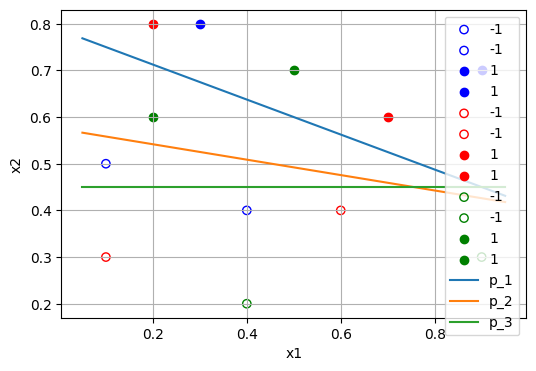

In [84]:
coeff_0 = w_j.value[0]
coeff_1 = w_j.value[1]
coeff_2 = w_j.value[2]
coeffs = [coeff_0, coeff_1, coeff_2]


def boundary_equation_2d(x1, coeff):
    w1 = coeff[0]
    w2 = coeff[1]
    b = coeff[2]

    x = np.hstack([x1, np.ones_like(x1)])
    # w = np.array([-w1/w2, -b/w2]).reshape(-1,1)
    w = np.array([-w1/w2, -b/w2 + 0.5/w2]).reshape(-1,1)

    return x @ w

test_x = np.linspace(0.05, 0.95, 100).reshape(-1,1)

test_y_1 = boundary_equation_2d(test_x, coeff_0)
test_y_2 = boundary_equation_2d(test_x, coeff_1)
test_y_3 = boundary_equation_2d(test_x, coeff_2)



plt.figure(figsize=(6,4))
colors = ['blue', 'red', 'green']

for j in range(len_j):
    for l in range(4):
        if L[j][l, 2] == 1:
            plt.scatter(L[j][l, 0], L[j][l, 1], c=colors[j], marker='o', label='1')
        else:
            plt.scatter(L[j][l, 0], L[j][l, 1], facecolors='none', edgecolors=colors[j], marker='o', label='-1')

plt.plot(test_x, test_y_1, label="p_1")
plt.plot(test_x, test_y_2, label="p_2")
plt.plot(test_x, test_y_3, label="p_3")


plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()